# Word Representation in Biomedical Domain

Before you start, please make sure you have read this notebook. You are encouraged to follow the recommendations but you are also free to develop your own solution from scratch. 

## Marking Scheme

- Biomedical imaging project: 40%
    - 20%: accuracy of the final model on the test set
    - 20%: rationale of model design and final report
- Natural language processing project: 40%
    - 30%: completeness of the project
    - 10%: final report
- Presentation skills and team work: 20%


This project forms 40\% of the total score for summer school. The marking scheme of each part of this project is provided below with a cap of 100\%.

You are allowed to use open source libraries as long as the libraries are properly cited in the code and final report. The usage of third-party code without proper reference will be treated as plagiarism, which will not be tolerated.

You are encouraged to develop the algorithms by yourselves (without using third-party code as much as possible). We will factor such effort into the marking process.

## Setup and Prerequisites 

Recommended environment

- Python 3.7 or newer
- Free disk space: 100GB

Download the data

```sh
# navigate to the data folder
cd data

# download the data file
# which is also available at https://www.semanticscholar.org/cord19/download
wget https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/2021-07-26/document_parses.tar.gz

# decompress the file which may take several minutes
tar -xf document_parses.tar.gz

# which creates a folder named document_parses
```

## Part 1 (20%): Parse the Data

The JSON files are located in two sub-folders in `document_parses`. You will need to scan all JSON files and extract text (i.e. `string`) from relevant fields (e.g. body text, abstract, titles).

You are encouraged to extract full article text from body text if possible. If the hardware resource is limited, you can extract from abstract or titles as alternatives. 

Note: The number of JSON files is around 425k so it may take more than 10 minutes to parse all documents.

For more information about the dataset: https://www.semanticscholar.org/cord19/download

Recommended output:

- A list of text (`string`) extracted from JSON files.

In [1]:
from __future__ import division, print_function, absolute_import
from six.moves import xrange

import numpy as np
import pandas as pd
¸
import re
import os
import re
import collections
import random
import urllib
import zipfile
import csv

from tqdm import tqdm

import nltk
from nltk.tokenize import word_tokenize

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable

import math
from functools import reduce


import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
##读取所有json文件路径信息

# 读取pdf_json文件夹中所有json文件的路径信息
root_path = '/kaggle/input/CORD-19-research-challenge/'
all_json = ! ls $root_path/document_parses/pdf_json #all_json储存所有json文件的路径信息
all_json = [root_path + "document_parses/pdf_json/" + s for s in all_json]

# 定义json文件读取函数，读取文件中的文章ID,摘要,正文三个信息
class FileReader:
    def __init__(self, file_path):
        with open(file_path) as file:
            content = json.load(file)
            self.paper_id = content['paper_id']
            self.abstract = []
            self.body_text = []
            # Abstract
            for entry in content['abstract']:
                self.abstract.append(entry['text'])
            # Body text
            for entry in content['body_text']:
                self.body_text.append(entry['text'])
            self.abstract = '\n'.join(self.abstract)
            self.body_text = '\n'.join(self.body_text)
    def __repr__(self):
        return f'{self.paper_id}: {self.abstract[:200]}... {self.body_text[:200]}...'

# 输出所有json文件数量
print(len(all_json))

247236


In [3]:
##读取json文件

# 当需要顺序读取文章时，注释掉后一块代码，取消注释此块代码
'''
paper_number = 1000
papers = [FileReader(all_json[i]) for i in range(paper_number)]
'''

# 当需要顺序读取摘要非空的文章时，注释掉前一块代码，取消注释此块代码
'''
paper_number = 1000
papers = []
count = 0
i = 0
while count < paper_number:
    paper = FileReader(all_json[i])
    if len(paper.abstract) == 0:
        i += 1
    else:
        papers.append(paper)
        i += 1
        count += 1
'''

# 当需要顺序读取全样本非空文章时，注释掉上面所有代码块，取消注释下方所有代码块
paper_number = len(all_json)
papers = []
count = 0
for i in tqdm(range(paper_number), total = paper_number):
    if count < paper_number:
        paper = FileReader(all_json[i])
        if len(paper.abstract) != 0:
            papers.append(paper)
            count += 1
        else:
            continue
    else:
        break

100%|██████████| 247236/247236 [32:22<00:00, 127.25it/s]


## Part 2 (30%): Tokenization

Traverse the extracted text and segment the text into words (or tokens).

The following tracks can be developed in independentely. You are encouraged to divide the workload to each team member.

Recommended output:

- Tokenizer(s) that is able to tokenize any input text.

Note: Because of the computation complexity of tokenizers, it may take hours/days to process all documents. Which tokenizer is more efficient? Any idea to speedup?

### Track 2.1 (10%): Use split()

Use the standard `split()` by Python.

### Track 2.2 (10%): Use NLTK or SciSpaCy

NLTK tokenizer: https://www.nltk.org/api/nltk.tokenize.html

SciSpaCy: https://github.com/allenai/scispacy

Note: You may need to install NLTK and SpaCy so please refer to their websites for installation instructions.

### Track 2.3 (10%): Use Byte-Pair Encoding (BPE)

Byte-Pair Encoding (BPE): https://huggingface.co/transformers/tokenizer_summary.html

Note: You may need to install Huggingface's transformers so please refer to its website for installation instructions.

### Track 2.4 (Bonus +5%): Build new Byte-Pair Encoding (BPE)

This track may be dependent on track 2.3.

The above pre-built tokenization methods may not be suitable for biomedical domain as the words/tokens (e.g. diseases, sympotoms, chemicals, medications, phenotypes, genotypes etc.) can be very different from the words/tokens commonly used in daily life. Can you build and train a new BPE model for biomedical domain in particular?

### Open Question (Optional):

- What are the pros and cons of the above tokenizers?

#### ***Track 2.1: Use split()***

In [4]:
##用Split方式进行tokenization
'''

# 分别读取每篇文章的摘要和正文，用split()方式进行tokenization
# 将拆分结果储存在一个列表中，每个列表代表一篇文章的拆分结果，最后将所有列表分别储存在abstract和body_text两个大列表中
abstract_list = []
body_text_list = []
for i in tqdm(range(len(papers)), total = len(papers)):
    abstract = papers[i].abstract
    body_text = papers[i].body_text
    abstract.replace('\n','')
    body_text.replace('\n','')
    abstract_split =  re.split('[\s;,.:()]\s*',abstract)
    body_text_split = re.split('[\s;,.:()]\s*',body_text)
    for i in range(abstract_split.count('')):
        abstract_split.remove('')
        abstract_list.append(abstract_split)
    for i in range(body_text_split.count('')):
        body_text_split.remove('')
        body_text_list.append(body_text_split)
        
'''

"\n\n# 分别读取每篇文章的摘要和正文，用split()方式进行tokenization\n# 将拆分结果储存在一个列表中，每个列表代表一篇文章的拆分结果，最后将所有列表分别储存在abstract和body_text两个大列表中\nabstract_list = []\nbody_text_list = []\nfor i in tqdm(range(len(papers)), total = len(papers)):\n    abstract = papers[i].abstract\n    body_text = papers[i].body_text\n    abstract.replace('\n','')\n    body_text.replace('\n','')\n    abstract_split =  re.split('[\\s;,.:()]\\s*',abstract)\n    body_text_split = re.split('[\\s;,.:()]\\s*',body_text)\n    for i in range(abstract_split.count('')):\n        abstract_split.remove('')\n        abstract_list.append(abstract_split)\n    for i in range(body_text_split.count('')):\n        body_text_split.remove('')\n        body_text_list.append(body_text_split)\n        \n"

#### ***Track 2.2: Use NLTK***

In [5]:
##用nltk中的word_tokenize方式,对所有paper的abstract进行tokenization

abstract_list = []
#body_text_list = []

for i in tqdm(range(len(papers)), total = len(papers)):
    abstract = papers[i].abstract
    abstract_nltk = word_tokenize(abstract)
    for word in abstract_nltk:
        if word.isalnum():
            continue
        else:
            while word in abstract_nltk:
                abstract_nltk.remove(word)
    abstract_nltk = [word.lower() for word in abstract_nltk]
    abstract_list.append(abstract_nltk)
    '''
    body_text = papers[i].body_text
    body_text_nltk = word_tokenize(body_text)
    for word in body_text_nltk:
        if word.isalnum():
            continue
        else:
            while word in body_text_nltk:
                body_text_nltk.remove(word)
    body_text_nltk = [word.lower() for word in body_text_nltk]
    body_text_list.append(body_text_nltk)
    '''

#print(abstract_list)
#print(body_text_list)

100%|██████████| 172068/172068 [11:19<00:00, 253.20it/s]


#### ***Track 2.3: Use Byte-Pair Encoding (BPE)***

In [6]:
##用BPE进行tokenization
'''

def get_stats(vocab):
    pairs = collections.defaultdict(int)
    for word, freq in vocab.items():
        symbols = word.split()
        for i in range(len(symbols) - 1):
            pairs[symbols[i], symbols[i + 1]] += freq
    return pairs


def merge_vocab(pair, v_in):
    v_out = {}
    bigram = re.escape(' '.join(pair))
    p = re.compile(r'(?<!\S)' + bigram + r'(?!\S)')
    for word in v_in:
        w_out = p.sub(''.join(pair), word)
        v_out[w_out] = v_in[word]
    return v_out


files = [] #所有文章组成的大列表
for i in range(len(papers)):
    abstract = papers[i].abstract
    files.append(abstract)
    #body_text = papers[i].body_text
    #files.append(body_text)


vocab = {}
for key in files:
    str_list = list(key)
    # 在单词中间加上空格
    for i in key:
        # 判断元素是否是大写
        if i.isupper():
            # 如果是大写就记录下标位置
            index = str_list.index(i)
            # 判断如果是第一个首字母则跳出本次循环
            if index == 0:
                continue
            # 修改数据，把大写转换成小写和添加空格
            str_list[index] = i.lower()
            str_list.insert(index, " ")

            # 转换成字符串
    newKey = " ".join(str_list)
    vocab[newKey] = vocab.get(key, 0) + 1

num_merges = 100
#num_merges = len(vocab)
for i in range(num_merges):
    pairs = get_stats(vocab)
    best = max(pairs, key=pairs.get)
    vocab = merge_vocab(best, vocab)

# 把vocab中的key存入一个list
keys = list(vocab.keys())
output = list()


for element in keys:
    element.replace('\n', '')
    new_list = re.split('[\s;,.:()]\s*',element)
    for i in range(new_list.count('')):
        new_list.remove('')
    for word in new_list:
        if word.isalnum():
            continue
        else:
            while word in new_list:
                new_list.remove(word)
    output.extend(new_list)

print(output)

'''

'\n\ndef get_stats(vocab):\n    pairs = collections.defaultdict(int)\n    for word, freq in vocab.items():\n        symbols = word.split()\n        for i in range(len(symbols) - 1):\n            pairs[symbols[i], symbols[i + 1]] += freq\n    return pairs\n\n\ndef merge_vocab(pair, v_in):\n    v_out = {}\n    bigram = re.escape(\' \'.join(pair))\n    p = re.compile(r\'(?<!\\S)\' + bigram + r\'(?!\\S)\')\n    for word in v_in:\n        w_out = p.sub(\'\'.join(pair), word)\n        v_out[w_out] = v_in[word]\n    return v_out\n\n\nfiles = [] #所有文章组成的大列表\nfor i in range(len(papers)):\n    abstract = papers[i].abstract\n    files.append(abstract)\n    #body_text = papers[i].body_text\n    #files.append(body_text)\n\n\nvocab = {}\nfor key in files:\n    str_list = list(key)\n    # 在单词中间加上空格\n    for i in key:\n        # 判断元素是否是大写\n        if i.isupper():\n            # 如果是大写就记录下标位置\n            index = str_list.index(i)\n            # 判断如果是第一个首字母则跳出本次循环\n            if index == 0:\n          

#### ***Track 2.4: Build new Byte-Pair Encoding (BPE)***

In [7]:
####用new Byte-Pair Encoding进行tokenization
'''

def get_stats(vocab):
    pairs = collections.defaultdict(int)
    for word, freq in vocab.items():
        symbols = word.split()
        for i in range(len(symbols) - 1):
            pairs[symbols[i], symbols[i + 1]] += freq
    return pairs


def merge_vocab(pair, v_in):
    v_out = {}
    bigram = re.escape(' '.join(pair))
    p = re.compile(r'(?<!\S)' + bigram + r'(?!\S)')
    for word in v_in:
        w_out = p.sub(''.join(pair), word)
        v_out[w_out] = v_in[word]
    return v_out


files = [] #所有文章组成的大列表
for i in range(len(papers)):
    abstract = papers[i].abstract
    files.append(abstract)
    #body_text = papers[i].body_text
    #files.append(body_text)


vocab = {}
for key in files:
    str_list = list(key)
    # 在单词中间加上空格
    for i in key:
        # 判断元素是否是大写
        if i.isupper():
            # 如果是大写就记录下标位置
            index = str_list.index(i)
            # 判断如果是第一个首字母则跳出本次循环
            if index == 0:
                continue
            # 修改数据，把大写转换成小写和添加空格
            str_list[index] = i.lower()
            str_list.insert(index, " ")

            # 转换成字符串
    newKey = " ".join(str_list)
    vocab[newKey] = vocab.get(key, 0) + 1

num_merges = 100
#num_merges = len(vocab)
for i in range(num_merges):
    pairs = get_stats(vocab)
    best = max(pairs, key=pairs.get)
    vocab = merge_vocab(best, vocab)

# 把vocab中的key存入一个list
keys = list(vocab.keys())
output = list()

with open('/kaggle/input/medical-dictionary/medical_dictionary.csv','r') as csvfile:
    reader = csv.reader(csvfile)
    medterm = [column[0] for column in reader]

for element in keys:
    element.replace('\n','')
    for word in medterm:
        if word == element:
            new_list1 = re.add(element)

output.extend(new_list1)
print(output)
'''

'\n\ndef get_stats(vocab):\n    pairs = collections.defaultdict(int)\n    for word, freq in vocab.items():\n        symbols = word.split()\n        for i in range(len(symbols) - 1):\n            pairs[symbols[i], symbols[i + 1]] += freq\n    return pairs\n\n\ndef merge_vocab(pair, v_in):\n    v_out = {}\n    bigram = re.escape(\' \'.join(pair))\n    p = re.compile(r\'(?<!\\S)\' + bigram + r\'(?!\\S)\')\n    for word in v_in:\n        w_out = p.sub(\'\'.join(pair), word)\n        v_out[w_out] = v_in[word]\n    return v_out\n\n\nfiles = [] #所有文章组成的大列表\nfor i in range(len(papers)):\n    abstract = papers[i].abstract\n    files.append(abstract)\n    #body_text = papers[i].body_text\n    #files.append(body_text)\n\n\nvocab = {}\nfor key in files:\n    str_list = list(key)\n    # 在单词中间加上空格\n    for i in key:\n        # 判断元素是否是大写\n        if i.isupper():\n            # 如果是大写就记录下标位置\n            index = str_list.index(i)\n            # 判断如果是第一个首字母则跳出本次循环\n            if index == 0:\n          

## Part 3 (30%): Build Word Representations

Build word representations for each extracted word. If the hardware resource is limited, you may limit the vocabulary size up to 10k words/tokens (or even smaller) and the dimension of representations up to 256.

The following tracks can be developed independently. You are encouraged to divide the workload to each team member.

### Track 3.1 (15%): Use N-gram Language Modeling

N-gram Language Modeling is to predict a target word by using `n` words from previous context. Specifically,

$P(w_i | w_{i-1}, w_{i-2}, ..., w_{i-n+1})$

For example, given a sentence, `"the main symptoms of COVID-19 are fever and cough"`, if $n=7$, we use previous context `["the", "main", "symptoms", "of", "COVID-19", "are"]` to predict the next word `"fever"`.

More to read: https://web.stanford.edu/~jurafsky/slp3/3.pdf

Recommended outputs:

- A fixed vector for each word/token.

### Track 3.2 (15%): Use Skip-gram with Negative Sampling

In skip-gram, we use a central word to predict its context. Specifically,

$P(w_{c-m}, ... w_{c-1}, w_{c+1}, ..., w_{c+m} | w_c)$

As the learning objective of skip-gram is computational inefficient (summation of entire vocabulary $|V|$), negative sampling is commonly applied to accelerate the training.

In negative sampling, we randomly select one word from the context as a positive sample, and randomly select $K$ words from the vocabulary as negative samples. As a result, the learning objective is updated to

$L = -\log\sigma(u^T_{t} v_c) - \sum_{k=1}^K\log\sigma(-u^T_k v_c)$, where $u_t$ is the vector embedding of positive sample from context, $u_k$ are the vector embeddings of negative samples, $v_c$ is the vector embedding of the central word, $\sigma$ refers to the sigmoid function.

More to read http://web.stanford.edu/class/cs224n/readings/cs224n-2019-notes01-wordvecs1.pdf section 4.3 and 4.4

Recommended outputs:

- A fixed vector for each word/token.

### Track 3.3 (Bonus +5%): Use Contextualised Word Representation by Masked Language Model (MLM)

BERT introduces a new language model for pre-training named Masked Language Model (MLM). The advantage of MLM is that the word representations by MLM will be contextualised.

For example, "stick" may have different meanings in different context. By N-gram language modeling and word2vec (skip-gram, CBOW), the word representation of "stick" is fixed regardless of its context. However, MLM will learn the representation of "stick" dynamatically based on context. In other words, "stick" will have different representations in different context by MLM.

More to read: http://jalammar.github.io/illustrated-bert/ and https://arxiv.org/pdf/1810.04805.pdf

Recommended outputs:

- An algorithm that is able to generate contextualised representation in real time.

#### ***Track 3.1:Use N-gram Language Modeling***

In [8]:
##用N-gram建立word representation
'''

CONTEXT_SIZE = 3  # 依据的单词数，希望由前面3个单词来预测这个单词
EMBEDDING_DIM = 10  # 词向量的维度

# 建立训练集，遍历整个abstract_list中的每一个abstract_nltk，将单词三个分组，前面两个作为输入，最后一个作为预测的结果。
trigrams = []
for abstract_nltk in abstract_list:
    trigram = [((abstract_nltk[i], abstract_nltk[i + 1], abstract_nltk[i + 2]), abstract_nltk[i + 3])
               for i in range(len(abstract_nltk) - 3)]
    trigrams.extend(trigram)
print("Length of trigrams: %d"%len(trigrams)) #打印训练集的长度

# 给每个单词编码，用数字表示单词，只有这样才能传入nn.Embedding得到词向量
text_words = []
for abstract in abstract_list:
    text_words.extend(abstract)
#print(text_words)
vocabulary = set([word for word in text_words])
vocabulary_size = len(vocabulary)
print("Length of vocabulary: %d"%len(vocabulary)) #打印训练集的长度
word2id = {word: i for i, word in enumerate(vocabulary)}  # 词在前，数在后
id2word = {word2id[word]: word for word in word2id}  # 数在前，词在后


# 定义N Gram模型
class n_gram(nn.Module):
    # 传入3个参数，单词总数、预测单词所依赖的单词数（这里为）、词向量维度
    def __init__(self, vocab_size, context_size=CONTEXT_SIZE, n_dim=EMBEDDING_DIM):
        super(n_gram, self).__init__()

        self.embed = nn.Embedding(vocab_size, n_dim)
        self.classify = nn.Sequential(
            nn.Linear(context_size * n_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, vocab_size)
        )

    def forward(self, x):
        voc_embed = self.embed(x)  # 得到词嵌入
        voc_embed = voc_embed.view(1, -1)  # 将两个词向量拼在一起 # view()函数作用是将一个多行的Tensor,拼接成一行。
        out = self.classify(voc_embed)  # 此时输出的维度是单词总数
        return out
    
    def extract(self, x):
        embeds = self.embed(x)
        return embeds

# 训练N-gram模型
net = n_gram(len(word2id))

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=1e-2, weight_decay=1e-5)

for e in range(1):
    train_loss = 0
    for word, label in trigrams:
        word = Variable(torch.LongTensor([word2id[i] for i in word])) # 将两个词作为输入
        label = Variable(torch.LongTensor([word2id[label]]))
        # 前向传播
        out = net(word)
        loss = criterion(out, label)
        train_loss += loss.item()
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if (e + 1) % 1 == 0:
        # print('epoch: {}, Loss: {:.6f}'.format(e + 1, train_loss / len(trigram)))
        print('epoch: {}, Loss: {:.6f}'.format(e + 1, loss))

net = net.eval()


# 输出词向量，vecs储存词向量，wors储存词,word2vec储存词-词向量对
vecs = net.extract(Variable(torch.LongTensor([v for v in word2id.values()])))
vecs = vecs.data.numpy()
wors = [w for w in word2id.keys()]
word2vec = {}
for i in range(len(wors)):
    word2vec[wors[i]] = list(vecs[i])


# 测试一下结果
word, label = trigrams[1] #选择下标为1的位置的词-词->词对
print('input: {}'.format(word))
print('label: {}'.format(label))
print()
word = Variable(torch.LongTensor([word2id[i] for i in word]))
out = net(word)
pred_label_idx = out.max(1)[1].item()
predict_word = id2word[pred_label_idx]
print('real word is {}, predicted word is {}'.format(label, predict_word))

'''

'\n\nCONTEXT_SIZE = 3  # 依据的单词数，希望由前面3个单词来预测这个单词\nEMBEDDING_DIM = 10  # 词向量的维度\n\n# 建立训练集，遍历整个abstract_list中的每一个abstract_nltk，将单词三个分组，前面两个作为输入，最后一个作为预测的结果。\ntrigrams = []\nfor abstract_nltk in abstract_list:\n    trigram = [((abstract_nltk[i], abstract_nltk[i + 1], abstract_nltk[i + 2]), abstract_nltk[i + 3])\n               for i in range(len(abstract_nltk) - 3)]\n    trigrams.extend(trigram)\nprint("Length of trigrams: %d"%len(trigrams)) #打印训练集的长度\n\n# 给每个单词编码，用数字表示单词，只有这样才能传入nn.Embedding得到词向量\ntext_words = []\nfor abstract in abstract_list:\n    text_words.extend(abstract)\n#print(text_words)\nvocabulary = set([word for word in text_words])\nvocabulary_size = len(vocabulary)\nprint("Length of vocabulary: %d"%len(vocabulary)) #打印训练集的长度\nword2id = {word: i for i, word in enumerate(vocabulary)}  # 词在前，数在后\nid2word = {word2id[word]: word for word in word2id}  # 数在前，词在后\n\n\n# 定义N Gram模型\nclass n_gram(nn.Module):\n    # 传入3个参数，单词总数、预测单词所依赖的单词数（这里为）、词向量维度\n    def __init__(self, vocab_siz

#### ***Track 3.2: Skip-gram***

In [9]:
##用Skip-gram建立word representation

# Training Parameters
learning_rate = 0.1
batch_size = 128
num_steps = 1000000
display_step = 10000
eval_step = 100000

# Evaluation Parameters
eval_words = ['disease', 'virus', 'symptoms', 'coronavirus', 'health', 'medical']

# Word2Vec Parameters
embedding_size = 200 # Dimension of the embedding vector
max_vocabulary_size = 1000 # Total number of different words in the vocabulary
min_occurrence = 10 # Remove all words that does not appears at least n times
skip_window = 3 # How many words to consider left and right
num_skips = 2 # How many times to reuse an input to generate a label
num_sampled = 64 # Number of negative examples to sample


text_words = []
for abstract in abstract_list:
    text_words.extend(abstract)
# Build the dictionary and replace rare words with UNK token
count = [('UNK', -1)]
# Retrieve the most common words
count.extend(collections.Counter(text_words).most_common(max_vocabulary_size - 1))
# Remove samples with less than 'min_occurrence' occurrences
for i in range(len(count) - 1, -1, -1):
    if count[i][1] < min_occurrence:
        count.pop(i)
    else:
        # The collection is ordered, so stop when 'min_occurrence' is reached
        break
# Compute the vocabulary size
vocabulary_size = len(count)
# Assign an id to each word
word2id = dict()
for i, (word, _)in enumerate(count):
    word2id[word] = i

data = list()
unk_count = 0
for word in text_words:
    # Retrieve a word id, or assign it index 0 ('UNK') if not in dictionary
    index = word2id.get(word, 0)
    if index == 0:
        unk_count += 1
    data.append(index)
count[0] = ('UNK', unk_count)
id2word = dict(zip(word2id.values(), word2id.keys()))

print("Words count:", len(text_words))
print("Unique words:", len(set(text_words)))
print("Vocabulary size:", vocabulary_size)
print("Most common words:", count[:10])

data_index = 0
# Generate training batch for the skip-gram model
def next_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    # get window size (words left and right + current one)
    span = 2 * skip_window + 1
    buffer = collections.deque(maxlen=span)
    if data_index + span > len(data):
        data_index = 0
    buffer.extend(data[data_index:data_index + span])
    data_index += span
    for i in range(batch_size // num_skips):
        context_words = [w for w in range(span) if w != skip_window]
        words_to_use = random.sample(context_words, num_skips)
        for j, context_word in enumerate(words_to_use):
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[context_word]
        if data_index == len(data):
            buffer.extend(data[0:span])
            data_index = span
        else:
            buffer.append(data[data_index])
            data_index += 1
    # Backtrack a little bit to avoid skipping words in the end of a batch
    data_index = (data_index + len(data) - span) % len(data)
    return batch, labels


# Input data
X = tf.placeholder(tf.int32, shape=[None])
# Input label
Y = tf.placeholder(tf.int32, shape=[None, 1])

# Ensure the following ops & var are assigned on CPU
# (some ops are not compatible on GPU)
with tf.device('/cpu:0'):
    # Create the embedding variable (each row represent a word embedding vector)
    embedding = tf.Variable(tf.random_normal([vocabulary_size, embedding_size]))
    # Lookup the corresponding embedding vectors for each sample in X
    X_embed = tf.nn.embedding_lookup(embedding, X)

    # Construct the variables for the NCE loss
    nce_weights = tf.Variable(tf.random_normal([vocabulary_size, embedding_size]))
    nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

# Compute the average NCE loss for the batch
loss_op = tf.reduce_mean(
    tf.nn.nce_loss(weights=nce_weights,
                   biases=nce_biases,
                   labels=Y,
                   inputs=X_embed,
                   num_sampled=num_sampled,
                   num_classes=vocabulary_size))

# Define the optimizer
optimizer = tf.train.GradientDescentOptimizer(learning_rate)
train_op = optimizer.minimize(loss_op)

# Evaluation
# Compute the cosine similarity between input data embedding and every embedding vectors
X_embed_norm = X_embed / tf.sqrt(tf.reduce_sum(tf.square(X_embed)))
embedding_norm = embedding / tf.sqrt(tf.reduce_sum(tf.square(embedding), 1, keepdims=True))
cosine_sim_op = tf.matmul(X_embed_norm, embedding_norm, transpose_b=True)

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

with tf.Session() as sess:

    # Run the initializer
    sess.run(init)

    # Testing data
    x_test = np.array([word2id[w] for w in eval_words])

    average_loss = 0
    for step in xrange(1, num_steps + 1):
        # Get a new batch of data
        batch_x, batch_y = next_batch(batch_size, num_skips, skip_window)
        # Run training op
        _, loss = sess.run([train_op, loss_op], feed_dict={X: batch_x, Y: batch_y})
        average_loss += loss

        if step % display_step == 0 or step == 1:
            if step > 1:
                average_loss /= display_step
            print("Step " + str(step) + ", Average Loss= " + \
                  "{:.4f}".format(average_loss))
            average_loss = 0

        # Evaluation
        if step % eval_step == 0 or step == 1:
            print("Evaluation...")
            sim = sess.run(cosine_sim_op, feed_dict={X: x_test})
            for i in xrange(len(eval_words)):
                top_k = 8  # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k + 1]
                log_str = '"%s" nearest neighbors:' % eval_words[i]
                for k in xrange(top_k):
                    log_str = '%s %s,' % (log_str, id2word[nearest[k]])
                print(log_str)
    
    word2vec = {}

    for i in tqdm(range(vocabulary_size), total = vocabulary_size):
        sWord = str(id2word.get(i))
        sVector = list(embedding_norm[i].eval())
        word2vec[sWord] = sVector
    #print(word2vec)

Words count: 37427413
Unique words: 379806
Vocabulary size: 1000
Most common words: [('UNK', 11476898), ('the', 2004488), ('of', 1496760), ('and', 1384401), ('in', 901552), ('to', 833899), ('a', 647237), ('with', 401979), ('for', 399518), ('is', 296096)]
Step 1, Average Loss= 495.2003
Evaluation...
"disease" nearest neighbors: chain, thus, practices, ability, acute, provided, temperature, additional,
"virus" nearest neighbors: pressure, underlying, entry, et, is, influenza, measure, develop,
"symptoms" nearest neighbors: public, existing, measure, 28, working, how, worldwide, specifically,
"coronavirus" nearest neighbors: examine, response, problem, support, severity, dataset, pathway, alternative,
"health" nearest neighbors: process, highly, children, pandemic, cancer, groups, agents, comorbidities,
"medical" nearest neighbors: use, according, during, fusion, pneumonia, appropriate, experience, such,
Step 10000, Average Loss= 24.5031
Step 20000, Average Loss= 6.8288
Step 30000, Averag

  0%|          | 3/1000 [00:00<00:43, 22.70it/s]

Step 1000000, Average Loss= 4.3002
Evaluation...
"disease" nearest neighbors: infection, by, however, which, coronavirus, to, acute, pandemic,
"virus" nearest neighbors: viral, in, infection, which, is, UNK, pandemic, its,
"symptoms" nearest neighbors: pneumonia, information, illness, life, during, patients, cases, such,
"coronavirus" nearest neighbors: disease, 2020, 2, for, by, respiratory, potential, it,
"health" nearest neighbors: public, healthcare, and, UNK, pandemic, has, impact, on,
"medical" nearest neighbors: participants, 3, use, way, such, students, march, only,


100%|██████████| 1000/1000 [01:42<00:00,  9.80it/s]


#### ***Track 3.3: Use Contextualised Word Representation by Masked Language Model (MLM)***

In [10]:
##用Masked Language Model(MLM)建立Contextualised Word Representation
'''

def prob_mask_like(t, prob):
    return torch.zeros_like(t).float().uniform_(0, 1) < prob

def mask_with_tokens(t, token_ids):
    init_no_mask = torch.full_like(t, False, dtype=torch.bool)
    mask = reduce(lambda acc, el: acc | (t == el), token_ids, init_no_mask)
    return mask

def get_mask_subset_with_prob(mask, prob):
    batch, seq_len, device = *mask.shape, mask.device
    max_masked = math.ceil(prob * seq_len)

    num_tokens = mask.sum(dim=-1, keepdim=True)
    mask_excess = (mask.cumsum(dim=-1) > (num_tokens * prob).ceil())
    mask_excess = mask_excess[:, :max_masked]

    rand = torch.rand((batch, seq_len), device=device).masked_fill(~mask, -1e9)
    _, sampled_indices = rand.topk(max_masked, dim=-1)
    sampled_indices = (sampled_indices + 1).masked_fill_(mask_excess, 0)

    new_mask = torch.zeros((batch, seq_len + 1), device=device)
    new_mask.scatter_(-1, sampled_indices, 1)
    return new_mask[:, 1:].bool()

# main class

class MLM(nn.Module):
    def __init__(
        self,
        transformer,
        mask_prob = 0.15,
        replace_prob = 0.9,
        num_tokens = None,
        random_token_prob = 0.,
        mask_token_id = 2,
        pad_token_id = 0,
        mask_ignore_token_ids = []):
        super().__init__()

        self.transformer = transformer

        # mlm related probabilities
        self.mask_prob = mask_prob
        self.replace_prob = replace_prob

        self.num_tokens = num_tokens
        self.random_token_prob = random_token_prob

        # token ids
        self.pad_token_id = pad_token_id
        self.mask_token_id = mask_token_id
        self.mask_ignore_token_ids = set([*mask_ignore_token_ids, pad_token_id])

    def forward(self, input, **kwargs):
        # do not mask [pad] tokens, or any other tokens in the tokens designated to be excluded ([cls], [sep])
        # also do not include these special tokens in the tokens chosen at random
        no_mask = mask_with_tokens(input, self.mask_ignore_token_ids)
        mask = get_mask_subset_with_prob(~no_mask, self.mask_prob)

        # get mask indices
        mask_indices = torch.nonzero(mask, as_tuple=True)

        # mask input with mask tokens with probability of `replace_prob` (keep tokens the same with probability 1 - replace_prob)
        masked_input = input.clone().detach()

        # if random token probability > 0 for mlm
        if self.random_token_prob > 0:
            assert self.num_tokens is not None, 'num_tokens keyword must be supplied when instantiating MLM if using random token replacement'
            random_token_prob = prob_mask_like(input, self.random_token_prob)
            random_tokens = torch.randint(0, self.num_tokens, input.shape, device=input.device)
            random_no_mask = mask_with_tokens(random_tokens, self.mask_ignore_token_ids)
            random_token_prob &= ~random_no_mask
            random_indices = torch.nonzero(random_token_prob, as_tuple=True)
            masked_input[random_indices] = random_tokens[random_indices]

        # [mask] input
        replace_prob = prob_mask_like(input, self.replace_prob)
        masked_input = masked_input.masked_fill(mask * replace_prob, self.mask_token_id)

        # mask out any tokens to padding tokens that were not originally going to be masked
        labels = input.masked_fill(~mask, self.pad_token_id)

        # get generator output and get mlm loss
        logits = self.transformer(masked_input, **kwargs)

        mlm_loss = F.cross_entropy(
            logits.transpose(1, 2),
            labels,
            ignore_index = self.pad_token_id
        )

        return mlm_loss
        
'''

"\n\ndef prob_mask_like(t, prob):\n    return torch.zeros_like(t).float().uniform_(0, 1) < prob\n\ndef mask_with_tokens(t, token_ids):\n    init_no_mask = torch.full_like(t, False, dtype=torch.bool)\n    mask = reduce(lambda acc, el: acc | (t == el), token_ids, init_no_mask)\n    return mask\n\ndef get_mask_subset_with_prob(mask, prob):\n    batch, seq_len, device = *mask.shape, mask.device\n    max_masked = math.ceil(prob * seq_len)\n\n    num_tokens = mask.sum(dim=-1, keepdim=True)\n    mask_excess = (mask.cumsum(dim=-1) > (num_tokens * prob).ceil())\n    mask_excess = mask_excess[:, :max_masked]\n\n    rand = torch.rand((batch, seq_len), device=device).masked_fill(~mask, -1e9)\n    _, sampled_indices = rand.topk(max_masked, dim=-1)\n    sampled_indices = (sampled_indices + 1).masked_fill_(mask_excess, 0)\n\n    new_mask = torch.zeros((batch, seq_len + 1), device=device)\n    new_mask.scatter_(-1, sampled_indices, 1)\n    return new_mask[:, 1:].bool()\n\n# main class\n\nclass MLM(nn.

## Part 4 (20%): Explore the Word Representations

The following tracks can be finished independently. You are encouraged to divide workload to each team member.

### Track 4.1 (5%): Visualise the word representations by t-SNE

t-SNE is an algorithm to reduce dimentionality and commonly used to visualise high-dimension vectors. Use t-SNE to visualise the word representations. You may visualise up to 1000 words as t-SNE is highly computationally complex.

More about t-SNE: https://lvdmaaten.github.io/tsne/

Recommende output:

- A diagram by t-SNE based on representations of up to 1000 words.

### Track 4.2 (5%): Visualise the Word Representations of Biomedical Entities by t-SNE

Instead of visualising the word representations of the entire vocabulary (or 1000 words that are selected at random), visualise the word representations of words which are biomedical entities. For example, fever, cough, diabetes etc. Based on the category of those biomedical entities, can you assign different colours to the entities and see if the entities from the same category can be clustered by t-SNE? For example, sinusitis and cough are both respirtory diseases so they should be assigned with the same colour and ideally their representations should be close to each other by t-SNE. Another example, Alzheimer and headache are neuralogical diseases which should be assigned by another colour.

Examples of biomedial ontology: https://www.ebi.ac.uk/ols/ontologies/hp and https://en.wikipedia.org/wiki/International_Classification_of_Diseases

Recommende output:

- A diagram with colours by t-SNE based on representations of biomedical entities.

### Track 4.3 (5%): Co-occurrence

- What are the biomedical entities which frequently co-occur with COVID-19 (or coronavirus)?

Recommended outputs:

- A sorted list of biomedical entities and description on how the entities are selected and sorted.

### Track 4.4 (5%): Semantic Similarity

- What are the biomedical entities which have closest semantic similarity COVID-19 (or coronavirus) based on word representations?

Recommended outputs:

- A sorted list of biomedical entities and description on how the entities are selected and sorted.

### Open Question (Optional): What else can you discover?

#### ***Pre-treatment: delete stopwords from word2vec***

In [11]:
##预处理，删除停用词

# 读取stopwords
with open('/kaggle/input/Stopwords/stopwords.txt') as txtfile:
    stopwords = [line.strip('\'\n') for line in txtfile.readlines()]
# 对word2vec删除stopwords
for word in stopwords:
    if word in word2vec.keys():
        del word2vec[word]

vecs = []
for vector in word2vec.values():
    vecs.append(vector)
X_reduced = vecs

#### ***Additional try: Visualise the word representations by PCA***

In [12]:
##额外尝试：利用主成分分析法（PCA）进行降维后可视化
'''
# 利用PCA算法进行降维
pca = PCA(n_components=0.95, random_state=42)
X_reduced = pca.fit_transform(vecs)
print(X_reduced.shape)
#print(X_reduced)

# 绘制所有单词向量的二维空间投影
#fig = plt.figure(figsize = (15, 15))
#ax = fig.gca()
#ax.set_facecolor('white')
'''

"\n# 利用PCA算法进行降维\npca = PCA(n_components=0.95, random_state=42)\nX_reduced = pca.fit_transform(vecs)\nprint(X_reduced.shape)\n#print(X_reduced)\n\n# 绘制所有单词向量的二维空间投影\n#fig = plt.figure(figsize = (15, 15))\n#ax = fig.gca()\n#ax.set_facecolor('white')\n"

#### ***Track 4.1: Visualise the word representations by t-SNE***

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 717 samples in 0.014s...
[t-SNE] Computed neighbors for 717 samples in 0.238s...
[t-SNE] Computed conditional probabilities for sample 717 / 717
[t-SNE] Mean sigma: 0.272980
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.935501
[t-SNE] KL divergence after 1000 iterations: 2.235911


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


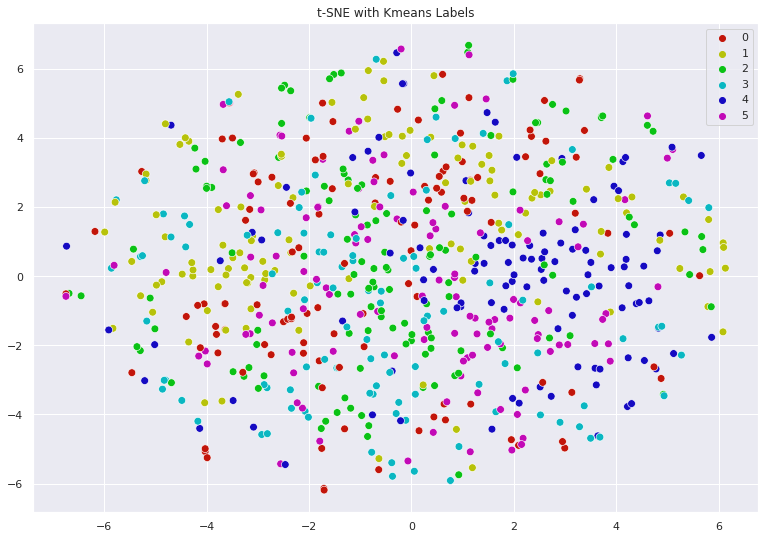

In [13]:
##通过t-SNE降维后，利用Kmeans聚类，绘制散点图进行可视化

# 用t-sne对词向量格式进行转换
tsne = TSNE(verbose=1, perplexity=50, random_state=42)  # Changed perplexity from 100 to 50 per FAQ
X_embedded = tsne.fit_transform(X_reduced)

# K-means聚类
k = 6
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X_reduced)

# 进行可视化
%matplotlib inline


# sns settings
sns.set(rc={'figure.figsize':(13,9)})

# colors
palette = sns.hls_palette(6, l=.4, s=.9)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y_pred, legend='full', palette=palette, s = 60)
plt.title('t-SNE with Kmeans Labels')
plt.savefig("improved_cluster_tsne.png")
plt.show()

#### ***Track 4.2: Visualise the Word Representations of Biomedical Entities by t-SNE***

dict_keys(['study', 'disease', 'health', 'data', 'infection', 'pandemic', 'virus', 'clinical', 'viral', 'model', 'respiratory', 'coronavirus', 'analysis', 'risk', 'cells', 'care', 'severe', 'protein', 'time', 'treatment', 'human', 'based', 'acute', 'cell', 'system', 'factors', 'social', 'control', 'mortality', 'response', 'ci', 'positive', 'public', 'review', 'population', 'development', 'patient', 'rate', 'age', 'viruses', 'impact', 'transmission', 'symptoms', 'rna', 'effects', 'vaccine', 'diseases', 'syndrome', 'medical', 'background', 'immune', 'people', 'total', 'activity', 'proteins', 'hospital', 'effective', 'outcomes', 'test', 'children', 'global', 'level', 'testing', 'method', 'expression', 'detection', 'evidence', 'specific', 'support', 'host', 'infectious', 'epidemic', 'lung', 'management', 'lower', 'systems', 'period', 'learning', 'low', 'influenza', 'common', 'diagnosis', 'multiple', 'binding', 'process', 'critical', 'quality', 'major', 'type', 'negative', 'cancer', 'gene',

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


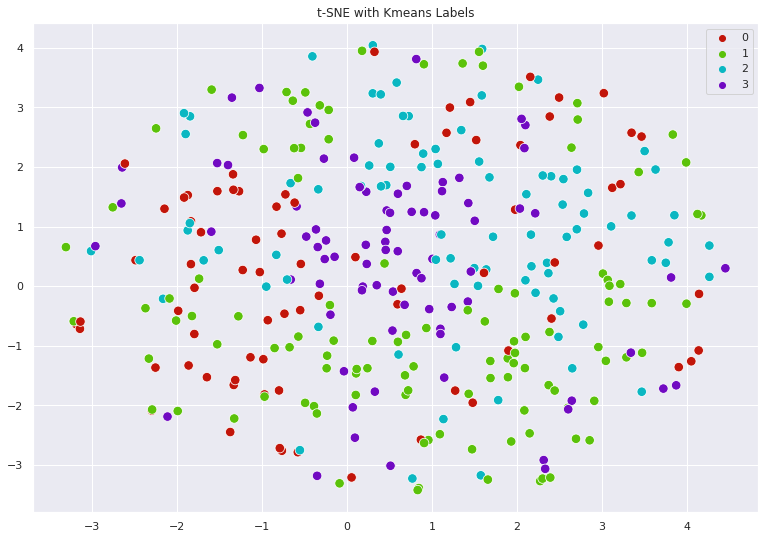

In [14]:
##筛选出生物医学领域的词汇，仅对这些词进行降维、聚类以及绘制散点图可视化

# 读取MedTerm的词库，并对全词库进行tokenization
with open('/kaggle/input/medical-dictionary/medical_dictionary.csv','r') as csvfile:
    reader = csv.reader(csvfile)
    medterm = [column[0] for column in reader]

medterm.pop(0)
medterm = ' '.join(medterm) 
medterm_nltk = word_tokenize(medterm)
medterm_nltk = list(set(medterm_nltk))

for word in medterm_nltk:
    if word.isdigit():
        while word in medterm_nltk:
            medterm_nltk.remove(word)
    elif word.isalnum():
        continue
    else:
        while word in medterm_nltk:
            medterm_nltk.remove(word)

medterm = []
for word in medterm_nltk:
    medterm.append(word.lower())

# 对medterm删除stopwords
for word in medterm:
    if word in stopwords:
        while word in medterm:
            medterm.remove(word)

# 查找在word2vec中的medterm中的单词，并赋键-值对给medterm_in_paper
medterm_in_paper = {}
for key, value in word2vec.items():
    if key in medterm:
        medterm_in_paper[key] = value
print(medterm_in_paper.keys())

## 进行可视化
medterm_in_paper_value = list(medterm_in_paper.values())

tsne = TSNE(verbose=1, perplexity=50, random_state=42)  # Changed perplexity from 100 to 50 per FAQ
X_embedded = tsne.fit_transform(medterm_in_paper_value)

# 用Kmeans进行聚类
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(medterm_in_paper_value)

# 绘图
%matplotlib inline

# sns settings
sns.set(rc={'figure.figsize':(13,9)})

# colors
palette = sns.hls_palette(4, l=.4, s=.9)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y_pred, legend='full', palette=palette, s = 90)
plt.title('t-SNE with Kmeans Labels')
plt.savefig("improved_cluster_tsne.png")
plt.show()

#### ***Track 4.3: Co-occurrence***

[('study', 103216), ('disease', 83882), ('health', 82972), ('data', 81891), ('infection', 81650), ('pandemic', 76861), ('virus', 70365), ('clinical', 59575), ('viral', 56136), ('model', 55571), ('respiratory', 54915), ('coronavirus', 53396), ('analysis', 51224), ('risk', 51035), ('cells', 49073), ('care', 45253), ('severe', 44077), ('protein', 42481), ('time', 41953), ('treatment', 41219), ('human', 41033), ('based', 35024), ('acute', 34813), ('cell', 34635), ('system', 34319), ('factors', 33368), ('social', 32500), ('control', 32267), ('mortality', 31644), ('response', 30296), ('ci', 30282), ('positive', 30200), ('public', 29461), ('review', 29074), ('population', 29056), ('development', 28978), ('patient', 28676), ('rate', 28212), ('age', 27893), ('viruses', 26902), ('impact', 26863), ('transmission', 26606), ('symptoms', 26543), ('rna', 25688), ('effects', 25436), ('vaccine', 25337), ('diseases', 24979), ('syndrome', 24940), ('medical', 24558), ('background', 24537)]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


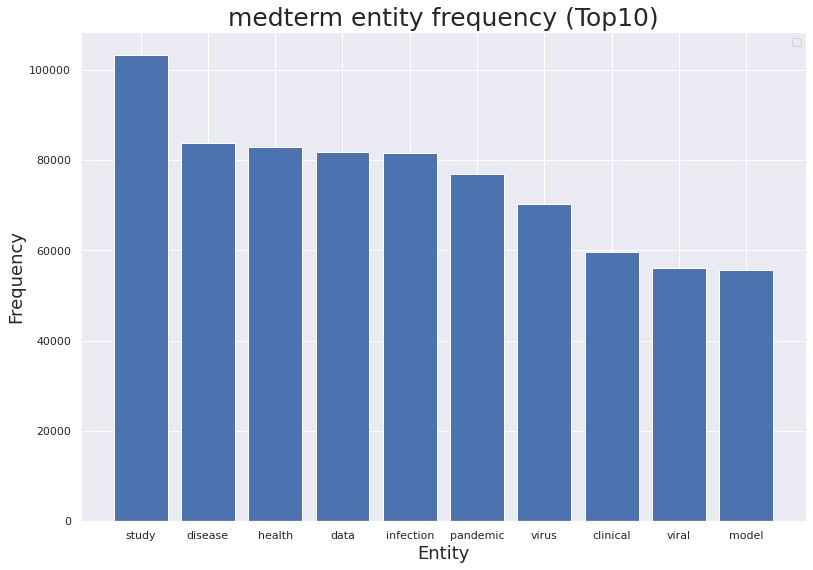

In [15]:
##额外尝试：统计所有在文中出现过的medterm词库中的词，排序后输出前50个，并绘制前10个的频次直方图

# 统计所有在文中出现过的medterm词库中的词的数量，排序后输出前50个
medterm_in_paper_count = {}
for word in word2vec.keys():
    if word in medterm:
        medterm_in_paper_count[word] = 0
for word in text_words:
    if word in medterm_in_paper_count:
        medterm_in_paper_count[word] += 1
medterm_in_paper_count = sorted(medterm_in_paper_count.items(),key=lambda x:x[1],reverse=True)
print(medterm_in_paper_count[:50])

# 进行可视化
font = FontProperties(size = 25)
plt.bar([medterm_in_paper_count[i][0] for i in range(10)],[medterm_in_paper_count[i][1] for i in range(10)])
plt.legend()
plt.xlabel('Entity',size = 18)
plt.ylabel('Frequency', size = 18)
plt.title('medterm entity frequency (Top10)', FontProperties=font)
plt.show()

Top 20 Frequency:
Rank:	Word:		Frequency:
1:	disease		17982
2:	2019		15523
3:	respiratory	12096
4:	syndrome	11131
5:	acute		10101
6:	2		9206
7:	pandemic	6165
8:	infection	2638
9:	patients	1996
10:	caused		1915
11:	outbreak	1860
12:	sars-cov-2	1621
13:	severe		1601
14:	human		1514
15:	east		1407
16:	background	1243
17:	sars		1235
18:	virus		1184
19:	spread		1121
20:	covid-19	1062

Rank:	Word:		Conditional Probability:
1:	disease		  9.1740%
2:	2019		  7.9195%
3:	respiratory	  6.1711%
4:	syndrome	  5.6788%
5:	acute		  5.1533%
6:	2		  4.6967%
7:	pandemic	  3.1452%
8:	infection	  1.3458%
9:	patients	  1.0183%
10:	caused		  0.9770%
11:	outbreak	  0.9489%
12:	sars-cov-2	  0.8270%
13:	severe		  0.8168%
14:	human		  0.7724%
15:	east		  0.7178%
16:	background	  0.6341%
17:	sars		  0.6301%
18:	virus		  0.6040%
19:	spread		  0.5719%
20:	covid-19	  0.5418%
[('disease', 0.09173974929978419), ('2019', 0.07919453500058671), ('respiratory', 0.061710822351806784), ('syndrome', 0.05678762926570448), ('ac

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


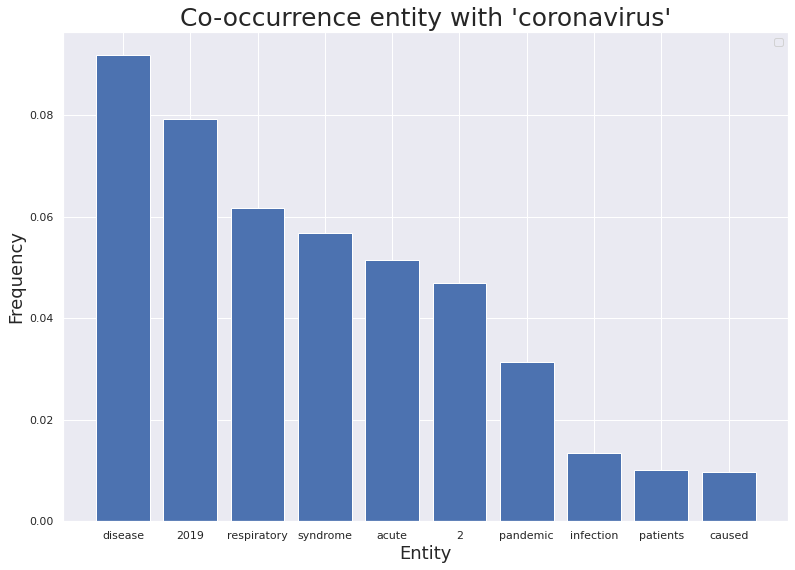

In [18]:
##统计所有在与coronavirus共现的medterm词库中的词，排序后输出前50个，并绘制前10个的频次直方图

# 统计所有在与coronavirus共现的medterm词库中的词的数量，排序后输出
co_occurrence = {}
for i in range(len(text_words)):
    if text_words[i] == 'coronavirus':
        for j in [i-3, i-2, i-1, i+1, i+2, i+3]:
            co_occurrence[text_words[j]] = 0
for i in range(len(text_words)):
    if text_words[i] == 'coronavirus':
        for j in [i-3, i-2, i-1, i+1, i+2, i+3]:
            co_occurrence[text_words[j]] += 1

# 删除co_occurrence中的stopword
co_occurrence_keys = []
for word in co_occurrence.keys():
    co_occurrence_keys.append(word)
for word in co_occurrence_keys:
    if word in stopwords:
        del co_occurrence[word]

# 打印输出前20个高频词及其频次
co_occurrence_num = sorted(co_occurrence.items(),key=lambda x:x[1],reverse=True)[:50]
print("Top 20 Frequency:")
print('Rank:\tWord:\t\tFrequency:')
for i in range(20):
    if len(co_occurrence_num[i][0]) < 8:
        print("%d:\t%s\t\t%d"%(i+1,co_occurrence_num[i][0],co_occurrence_num[i][1]))
    else:
        print("%d:\t%s\t%d"%(i+1,co_occurrence_num[i][0],co_occurrence_num[i][1]))
print()

# 计算条件概率
co_occurrence_all = sum(co_occurrence.values())
for word in co_occurrence.keys():
    co_occurrence[word] = co_occurrence[word]/co_occurrence_all

# 打印输出前20个高频词及其条件概率
co_occurrence_prob = sorted(co_occurrence.items(),key=lambda x:x[1],reverse=True)[:50]
print('Rank:\tWord:\t\tConditional Probability:')
for i in range(20):
    if len(co_occurrence_prob[i][0]) < 8:
        print("%d:\t%s\t\t  %.4f%%"%(i+1,co_occurrence_prob[i][0],co_occurrence_prob[i][1]*100))
    else:
        print("%d:\t%s\t  %.4f%%"%(i+1,co_occurrence_prob[i][0],co_occurrence_prob[i][1]*100))

print(sorted(co_occurrence.items(),key=lambda x:x[1],reverse=True)[:50])

##进行可视化
co_occurrence = sorted(co_occurrence.items(),key=lambda x:x[1],reverse=True)[:50]
font = FontProperties(size = 25)
plt.bar([co_occurrence[i][0] for i in range(10)],[co_occurrence[i][1] for i in range(10)])
plt.legend()
plt.xlabel('Entity',size = 18)
plt.ylabel('Frequency', size = 18)
plt.title('Co-occurrence entity with \'coronavirus\'', FontProperties=font)
plt.show()

In [ ]:
##额外尝试：统计文中所有单词的共现频次，按照word2id中的顺序储存在矩阵中，进行条件概率计算
##PS：此部分矩阵运算量巨大，由于非任务所要求，因此正常运行时不执行此代码块，
'''

co_occurrence_matrix = np.zeros((vocabulary_size, vocabulary_size))
for i in range(vocabulary_size):
    word = id2word.get(i)
    if i != 0:
        for j in range(3, len(text_words)-3):
            if text_words[j] == word:
                for k in [j-3, j-2, j-1, j+1, j+2, j+3]:
                    if text_words[k] in word2id.keys():
                        co_occurrence_matrix[i][word2id.get(text_words[k])] += 1
                    else:
                        co_occurrence_matrix[i][0] += 1
    else:
        for j in range(3, len(text_words)-3):
            if (text_words[j] in word2id.keys()) == False:
                for k in [j-3, j-2, j-1, j+1, j+2, j+3]:
                    if text_words[k] in word2id.keys():
                        co_occurrence_matrix[0][word2id.get(text_words[k])] += 1
                    else:
                        co_occurrence_matrix[0][0] += 1

# 对共现矩阵进行标准化（计算条件概率）
co_occurrence_matrix_norm = np.zeros((vocabulary_size, vocabulary_size))
for i in range(vocabulary_size):
    for j in range(vocabulary_size):
        co_occurrence_matrix_norm[i] =  co_occurrence_matrix[i]/co_occurrence_matrix[i].sum()

# 按顺序列举与coronavirus共现的高频医学词及其条件概率
co_occurrence_matrix_norm[word2id['coronavirus']] 
co_occurrence_coronavirus = {}
for i in range(1, vocabulary_size):
    word = id2word.get(i)
    co_occurrence_coronavirus[word] = co_occurrence_matrix_norm[word2id['coronavirus']][i]
#co_occurrence_coronavirus = sorted(co_occurrence_coronavirus.items(),key=lambda x:x[1],reverse=True)
#print(co_occurrence_coronavirus[:50])

# 删除co_occurrence_coronavirus中的stopword
co_occurrence_coronavirus_keys = []
for word in co_occurrence_coronavirus.keys():
    co_occurrence_coronavirus_keys.append(word)
for word in co_occurrence_coronavirus_keys:
    if word in stopwords:
        del co_occurrence_coronavirus[word]
co_occurrence_coronavirus = sorted(co_occurrence_coronavirus.items(),key=lambda x:x[1],reverse=True)

# 打印输出与coronavirus共现的前20个删除stopword后的高频医学词及其条件概率

######这里的输出函数还需要改
#for i in range(20):
#    print(f'{i + 1}: %sf'%(co_occurrence_coronavirus[i][0], co_occurrence_coronavirus[i][1]))
print(co_occurrence_coronavirus[:20])

'''

#### ***Track 4.4: Semantic Similarity***

In [19]:
##计算所有单词与coronavirus的余弦相似性，输出排序后的结果
similarity_dic = {}
for key, value in medterm_in_paper.items():
    similarity_dic[key] = 0

for word in medterm_in_paper.keys():
    similarity_dic[word] = float(cosine_similarity(np.array(medterm_in_paper['coronavirus']).reshape(1,200),np.array(medterm_in_paper[word]).reshape(1,200)))
similarity_dic = sorted(similarity_dic.items(),key=lambda x:x[1],reverse=True)

# 输出前20个相似性最高的词及其余弦相似度
print('Rank:\tWord:\t\tCosine Similarity:')
for i in range(20):
    if len(similarity_dic[i][0]) < 8:
        print("%d:\t%s\t\t     %.6f"%(i+1,similarity_dic[i][0],similarity_dic[i][1]))
    else:
        print("%d:\t%s\t     %.6f"%(i+1,similarity_dic[i][0],similarity_dic[i][1]))

Rank:	Word:		Cosine Similarity:
1:	coronavirus	     1.000000
2:	disease		     0.490548
3:	respiratory	     0.403659
4:	support		     0.390922
5:	severe		     0.369879
6:	response	     0.367356
7:	infection	     0.349254
8:	dna		     0.339842
9:	pathway		     0.335296
10:	effective	     0.330768
11:	mild		     0.328913
12:	strain		     0.318528
13:	inflammation	     0.318485
14:	negative	     0.316020
15:	guidelines	     0.315102
16:	illness		     0.315080
17:	activity	     0.310179
18:	cell		     0.309503
19:	icu		     0.304200
20:	domain		     0.301039


## Part 5 (Bonus +10%): Open Challenge: Mining Biomedical Knowledge

A fundamental task in clinical/biomedical natural language processing is to extract intelligence from biomedical text corpus automatically and efficiently. More specifically, the intelligence may include biomedical entities mentioned in text, relations between biomedical entities, clinical features of patients, progression of diseases, all of which can be used to predict, understand and improve patients' outcomes. 

This open challenge is to build a biomedical knowledge graph based on the CORD-19 dataset and mine useful information from it. We recommend the following steps but you are also encouraged to develop your solution from scratch.

### Extract Biomedical Entities from Text

Extract biomedical entities (such as fever, cough, headache, lung cancer, heart attack) from text. Note that:

- The biomedical entities may consist of multiple words. For example, heart attack, multiple myeloma etc.
- The biomedical entities may be written in synoynms. For example, low blood pressure for hypotension.
- The biomedical entities may be written in different forms. For example, smoking, smokes, smoked.

### Extract Relations between Biomedical Entities

Extract relations between biomedical entities based on their appearance in text. You may define a relation between biomedical entities by one or more of the following criteria:

- The biomedical entities frequentely co-occuer together.
- The biomedical entities have similar word representations.
- The biomedical entities have clear relations based on textual narratives. For example, "The most common symptoms for COVID-19 are fever and cough" so we know there are relations between "COVID-19", "fever" and "cough".

### Build a Biomedical Knowledge Graph of COVID-19

Build a knoweledge graph based on the results from track 5.1 and 5.2 and visualise it.

In [ ]:
###################
#还没来得及做
#但我们觉得这部分的任务很有挑战性和很有意思
#我们在将来会对这部分继续进行探索......
###################